# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
#import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go # добавила
import warnings; warnings.filterwarnings(action = 'ignore') 
from datetime import datetime, timedelta
from scipy import stats as st
from scipy.stats.stats import pearsonr

In [2]:
try:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep = '\t')

In [3]:
# Посмотрим рандомные строки из таблицы
pd.set_option('display.max_columns', None)
data.sample(n=10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
13547,7,2900000.0,30.0,2015-03-10T00:00:00,1,2.75,23.0,20.0,19,False,False,False,5.00,2.0,Санкт-Петербург,21460.0,16788.0,0.0,NaN,1.0,170.0,576.0
15849,8,2200000.0,56.3,2016-09-28T00:00:00,3,2.50,5.0,40.8,4,NaN,False,False,6.00,NaN,Луга,NaN,NaN,NaN,NaN,NaN,NaN,582.0
17826,9,6600000.0,65.0,2018-08-14T00:00:00,2,NaN,19.0,31.0,8,NaN,False,False,11.00,NaN,Санкт-Петербург,37717.0,14561.0,0.0,NaN,0.0,NaN,132.0
13645,16,5100000.0,62.0,2018-02-01T00:00:00,3,2.60,9.0,40.4,6,NaN,False,False,9.80,2.0,Санкт-Петербург,23803.0,11373.0,0.0,NaN,0.0,NaN,201.0
11865,18,4850000.0,44.5,2017-12-07T00:00:00,1,NaN,15.0,18.6,7,NaN,False,False,9.10,1.0,Санкт-Петербург,13990.0,12786.0,0.0,NaN,0.0,NaN,47.0
20573,20,4900000.0,62.0,2017-08-08T00:00:00,3,NaN,9.0,39.0,8,NaN,False,False,8.00,0.0,Санкт-Петербург,43316.0,15819.0,0.0,NaN,0.0,NaN,60.0
18028,11,3500000.0,31.0,2019-04-17T00:00:00,0,NaN,25.0,NaN,2,NaN,True,False,NaN,NaN,Санкт-Петербург,21460.0,16788.0,0.0,NaN,1.0,170.0,NaN
21107,10,9500000.0,145.0,2018-09-24T00:00:00,5,2.90,3.0,64.0,3,NaN,False,False,22.00,NaN,деревня Новое Девяткино,NaN,NaN,NaN,NaN,NaN,NaN,120.0
10621,17,5000000.0,42.0,2019-01-26T00:00:00,1,2.50,10.0,18.7,10,False,False,False,10.84,2.0,Санкт-Петербург,45207.0,17931.0,0.0,NaN,0.0,NaN,11.0
11781,8,5100000.0,60.0,2015-01-20T00:00:00,2,NaN,9.0,31.0,6,NaN,False,False,9.00,2.0,Санкт-Петербург,40880.0,16747.0,0.0,NaN,0.0,NaN,743.0


In [4]:
# Посмотрим типы данных и кол-во ненулевых значений
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

B таблице двадцать два столбца; количество значений в столбцах различается, что говорит о пропусках значений. Так же есть нарушения в стилистике в наименованиях столбцов.

In [5]:
# Посмотрим теперь в процентах
data.isnull().sum().sort_values()/data.shape[0]*100

total_images             0.000000
open_plan                0.000000
floor                    0.000000
rooms                    0.000000
studio                   0.000000
total_area               0.000000
last_price               0.000000
first_day_exposition     0.000000
locality_name            0.206760
floors_total             0.362885
living_area              8.029875
kitchen_area             9.612220
days_exposition         13.422507
ponds_around3000        23.283683
parks_around3000        23.283683
cityCenters_nearest     23.287902
airports_nearest        23.384953
ceiling_height          38.799105
balcony                 48.605426
ponds_nearest           61.559559
parks_nearest           65.909954
is_apartment            88.290645
dtype: float64

In [6]:
# Получим общую инф-ию о количественных данных в таблице data
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


Виден большой разброс в данных, часть данных вызывает вопросы (например, высота потолка - 100м или жилой дом из 60-ти этажей).

array([[<Axes: title={'center': 'total_images'}>,
        <Axes: title={'center': 'last_price'}>,
        <Axes: title={'center': 'total_area'}>,
        <Axes: title={'center': 'rooms'}>],
       [<Axes: title={'center': 'ceiling_height'}>,
        <Axes: title={'center': 'floors_total'}>,
        <Axes: title={'center': 'living_area'}>,
        <Axes: title={'center': 'floor'}>],
       [<Axes: title={'center': 'kitchen_area'}>,
        <Axes: title={'center': 'balcony'}>,
        <Axes: title={'center': 'airports_nearest'}>,
        <Axes: title={'center': 'cityCenters_nearest'}>],
       [<Axes: title={'center': 'parks_around3000'}>,
        <Axes: title={'center': 'parks_nearest'}>,
        <Axes: title={'center': 'ponds_around3000'}>,
        <Axes: title={'center': 'ponds_nearest'}>],
       [<Axes: title={'center': 'days_exposition'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

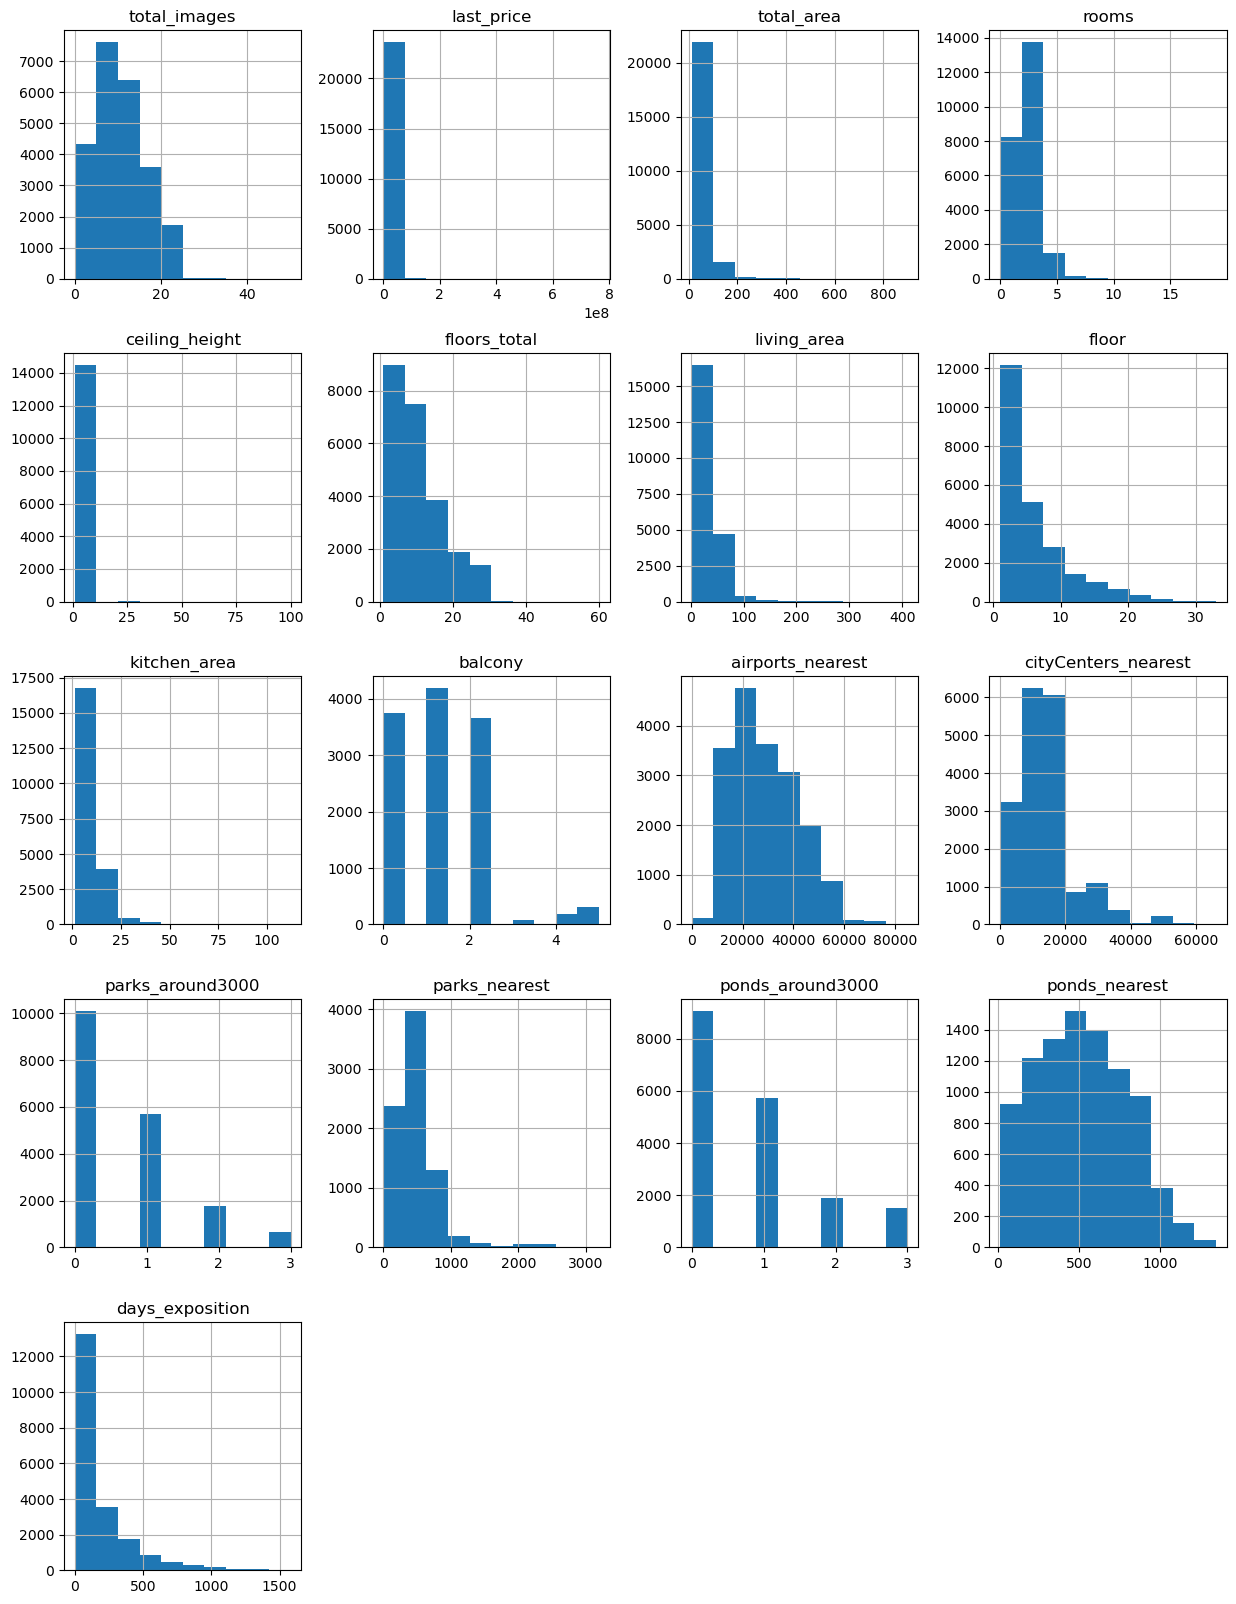

In [7]:
data.hist(figsize=(15, 20))

**Вывод:**

В каждой строке таблицы — данные об объявлении о продаже квартиры. Предварительно можно утверждать, что информации достаточно: параметров много, есть из чего выбрать.

При этом заметны пропуски в данных, по ряду признаков есть аномальные значения, возможны дубликаты, и, скорее всего, потребуется изменение формата в колонках для удобства. Так же, таблица достаточно большая, необходимо категоризировать ее и укрупнить данные для бОльшей наглядности.

Приступаем к предобработке данных.

### Предобработка данных

Для начала приведем наименования столбцов к единому стилю.

In [8]:
data = data.rename(columns={'cityCenters_nearest': 'city_centers_nearest', 
                        'parks_around3000': 'parks_around_3000', 
                        'ponds_around3000': 'ponds_around_3000',
                       })
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around_3000', 'parks_nearest', 'ponds_around_3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

In [9]:
# Смотрим количество пропущенных значений
data.isnull().sum().sort_values()

total_images                0
open_plan                   0
floor                       0
rooms                       0
studio                      0
total_area                  0
last_price                  0
first_day_exposition        0
locality_name              49
floors_total               86
living_area              1903
kitchen_area             2278
days_exposition          3181
ponds_around_3000        5518
parks_around_3000        5518
city_centers_nearest     5519
airports_nearest         5542
ceiling_height           9195
balcony                 11519
ponds_nearest           14589
parks_nearest           15620
is_apartment            20924
dtype: int64

In [10]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [11]:
# Начнем с названия города.
# Много городков, посмотрим что будет, если изменить регистр букв
len(data['locality_name'].unique())

365

In [12]:
data['locality_name'] = data['locality_name'].str.lower()
# Не помогло

In [13]:
data['locality_name'].unique()

array(['санкт-петербург', 'посёлок шушары', 'городской посёлок янино-1',
       'посёлок парголово', 'посёлок мурино', 'ломоносов', 'сертолово',
       'петергоф', 'пушкин', 'деревня кудрово', 'коммунар', 'колпино',
       'поселок городского типа красный бор', 'гатчина', 'поселок мурино',
       'деревня фёдоровское', 'выборг', 'кронштадт', 'кировск',
       'деревня новое девяткино', 'посёлок металлострой',
       'посёлок городского типа лебяжье',
       'посёлок городского типа сиверский', 'поселок молодцово',
       'поселок городского типа кузьмоловский',
       'садовое товарищество новая ропша', 'павловск',
       'деревня пикколово', 'всеволожск', 'волхов', 'кингисепп',
       'приозерск', 'сестрорецк', 'деревня куттузи', 'посёлок аннино',
       'поселок городского типа ефимовский', 'посёлок плодовое',
       'деревня заклинье', 'поселок торковичи', 'поселок первомайское',
       'красное село', 'посёлок понтонный', 'сясьстрой', 'деревня старая',
       'деревня лесколово', '

In [14]:
# Возможно, есть проблема с буквой Ё
# Проверим
data['locality_name'] = data['locality_name'].str.replace('ё', 'е', regex=True)
len(data['locality_name'].unique())

331

In [15]:
data['locality_name'].isna().sum()

49

In [16]:
# Удалим строки без города, они будут мешать в анализе, не понятно, где эти квартиры.
data = data.dropna(subset=['locality_name'])
data['locality_name'].isna().sum()

0

In [17]:
# Заменим пропуски в days_exposition на 9999 и заменим тип данных на int (далее в иследовании строки со значением "9999" учитывать не будем)
data['days_exposition'] = data['days_exposition'].fillna(value=9999).astype('int')

In [18]:
# Переведем столбец с датой в формат даты без времени, т.к. время не указано
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%d')
data['first_day_exposition'].describe()

count                   23650
unique                   1491
top       2018-02-01 00:00:00
freq                      368
first     2014-11-27 00:00:00
last      2019-05-03 00:00:00
Name: first_day_exposition, dtype: object

In [19]:
# Посмотрим параметр ceiling_height
data['ceiling_height'].describe()

count    14490.000000
mean         2.771287
std          1.261593
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

In [20]:
# Медиана от среднего отличается не сильно из-за этих выбросов во всей выборке
# Заполним пропуски медианным значением
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

In [21]:
# Заменим пропуски в balcony на 0 и изменим тип данных на int
data['balcony'] = data['balcony'].fillna(value=0).astype(int)

In [22]:
# Столбец апартаменты видимо появился не вместе с началом ведения записей или люди пропускали эту графу при заполнении 
# Все пропущенные значения заменим на False
data['is_apartment'] = data['is_apartment'].fillna(False)

In [23]:
# Посмотрим данные с пропущенными значениями в floors_total - оставим как есть
data[data['floors_total'].isna()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
186,12,11640000.0,65.2,2018-10-02,2,2.65,NaN,30.80,4,False,False,False,12.00,0,санкт-петербург,39197.0,12373.0,1.0,123.0,0.0,NaN,49
237,4,2438033.0,28.1,2016-11-23,1,2.65,NaN,20.75,1,False,False,False,NaN,0,санкт-петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,251
457,4,9788348.0,70.8,2015-08-01,2,2.65,NaN,38.40,12,False,False,False,10.63,0,санкт-петербург,37364.0,8322.0,2.0,309.0,2.0,706.0,727
671,4,6051191.0,93.6,2017-04-06,3,2.65,NaN,47.10,8,False,False,False,16.80,0,санкт-петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,123
1757,5,3600000.0,39.0,2017-04-22,1,2.65,NaN,NaN,9,False,False,False,NaN,0,санкт-петербург,22735.0,11618.0,1.0,835.0,1.0,652.0,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22542,5,8500000.0,63.5,2017-05-24,2,2.80,NaN,NaN,3,False,False,False,NaN,0,санкт-петербург,51340.0,15363.0,0.0,NaN,1.0,853.0,512
22656,4,4574160.0,64.5,2017-04-02,2,2.65,NaN,31.70,20,False,False,False,14.40,0,санкт-петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,127
22808,0,14569263.0,110.4,2016-11-20,3,2.65,NaN,45.38,6,False,False,False,23.42,0,санкт-петербург,19095.0,4529.0,0.0,NaN,0.0,NaN,260
23590,0,21187872.0,123.3,2017-04-25,3,2.65,NaN,50.40,18,False,False,False,23.60,0,санкт-петербург,19095.0,4529.0,0.0,NaN,0.0,NaN,104


In [24]:
# Приводим на тип int количество парков. Заменяем пропущенные значения на 0
data['parks_around_3000'] = data['parks_around_3000'].fillna(value=0).astype(int)
# Приводим на тип int количество прудов. Заменяем пропущенные значения на 0
data['ponds_around_3000'] = data['ponds_around_3000'].fillna(value=0).astype(int)

In [25]:
# Заменяем пустые значения жилой площади и площади кухни
living_ratio = (data['living_area'].mean())/(data['total_area'].mean())
data['living_area'].fillna(living_ratio*(data['total_area']), inplace=True)
kitchen_ratio = (data['kitchen_area'].mean())/(data['total_area'].mean())
data['kitchen_area'].fillna(kitchen_ratio*(data['total_area']), inplace=True)

**Работа с редкими и выбивающимися значениями**

In [26]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
count,23650.000000,2.365000e+04,23650.000000,23650.000000,23650.000000,23565.000000,23650.00000,23650.000000,23650.000000,23650.000000,18116.000000,18139.000000,23650.000000,8064.000000,23650.000000,9085.000000,23650.000000
mean,9.862326,6.541127e+06,60.329069,2.070106,2.724311,10.675875,34.58242,5.893277,10.502875,0.591712,28803.225878,14197.860742,0.469091,490.830729,0.590359,518.059879,1500.923383
std,5.682278,1.089640e+07,35.661808,1.078620,0.989255,6.594823,22.35971,4.883317,6.037440,0.959662,12637.314144,8606.830295,0.748458,342.554386,0.883539,277.841733,3355.769515
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.00000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.600000,5.000000,19.00000,2.000000,7.000000,0.000000,18575.750000,9241.000000,0.000000,288.000000,0.000000,293.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.00000,4.000000,9.000000,0.000000,26756.500000,13105.000000,0.000000,454.500000,0.000000,502.000000,124.000000
75%,14.000000,6.799000e+06,69.700000,3.000000,2.700000,16.000000,42.10000,8.000000,12.000000,1.000000,37294.000000,16293.000000,1.000000,612.000000,1.000000,730.000000,390.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.70000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,9999.000000


**Проверим с помощью графика размаха следующие данные:**
- ceiling_height
- last_price
- total_area
- rooms
- days_exposition

**Начнем с высоты потолков**

count    23650.000000
mean         2.724311
std          0.989255
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

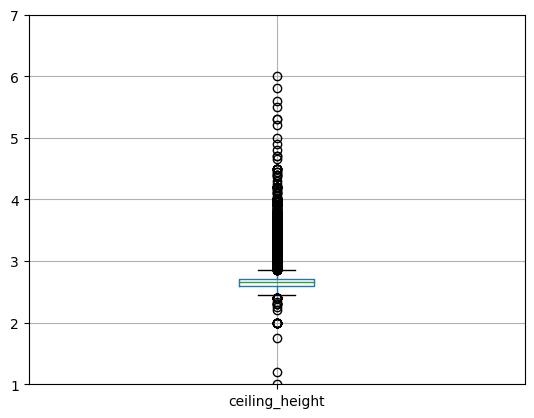

In [27]:
plt.ylim(1, 7)
data.boxplot('ceiling_height')
data['ceiling_height'].describe()

Видим, что очень мало квартир с потолками выше 7 метров и я сомневаюсь, что есть квартиры с потолком ниже 2 м.
Оставляю до 7 метров, т.к. квартиры могут быть двухуровневые с открытым пространством.

In [28]:
# Проверим процент потолков, которые выше 7 метров
len(data.query('ceiling_height > 7')) / len(data)

0.001226215644820296

In [29]:
# Проверим процент потолков, которые ниже 2 метров
len(data.query('ceiling_height < 2')) / len(data)

0.00012684989429175475

In [30]:
# Процент маленький, поэтому избавимся от этих данных
data = data.loc[data['ceiling_height'] <= 7]
data = data.loc[data['ceiling_height'] >= 2]

**Посмотрим общую стоимость квартир**

In [31]:
data.sort_values(by='last_price', ascending=False).head(20)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
12971,19,763000000.0,400.0,2017-09-30,7,2.65,10.0,250.000000,10,False,False,False,70.058451,2,санкт-петербург,25108.0,3956.0,1,530.0,3,756.0,33
19540,8,420000000.0,900.0,2017-12-06,12,2.80,25.0,409.700000,25,False,False,False,112.000000,0,санкт-петербург,30706.0,7877.0,0,NaN,2,318.0,106
14706,15,401300000.0,401.0,2016-02-20,5,2.65,9.0,204.000000,9,False,False,False,24.000000,3,санкт-петербург,21912.0,2389.0,1,545.0,1,478.0,393
1436,19,330000000.0,190.0,2018-04-04,3,3.50,7.0,95.000000,5,False,False,False,40.000000,0,санкт-петербург,23011.0,1197.0,3,519.0,3,285.0,233
15651,20,300000000.0,618.0,2017-12-18,7,3.40,7.0,258.000000,5,False,False,False,70.000000,0,санкт-петербург,32440.0,5297.0,0,NaN,2,198.0,111
22831,18,289238400.0,187.5,2019-03-19,2,3.37,6.0,63.700000,6,False,False,False,30.200000,0,санкт-петербург,22494.0,1073.0,3,386.0,3,188.0,9999
16461,17,245000000.0,285.7,2017-04-10,6,3.35,7.0,182.800000,4,False,False,False,29.800000,0,санкт-петербург,33143.0,6235.0,3,400.0,3,140.0,249
13749,7,240000000.0,410.0,2017-04-01,6,3.40,7.0,218.000000,7,False,False,False,40.000000,0,санкт-петербург,32440.0,5297.0,0,NaN,2,198.0,199
5893,3,230000000.0,500.0,2017-05-31,6,2.65,7.0,285.503788,7,False,False,False,40.000000,0,санкт-петербург,32440.0,5297.0,0,NaN,2,198.0,50
8900,13,190870000.0,268.0,2016-03-25,3,2.65,8.0,132.000000,7,False,False,False,40.000000,0,санкт-петербург,32440.0,5297.0,0,NaN,2,198.0,901


count    2.361800e+04
mean     6.543530e+06
std      1.090314e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

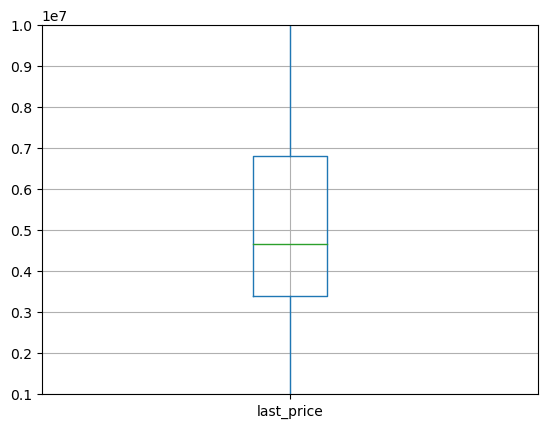

In [32]:
plt.ylim(1000000, 10000000)
data.boxplot('last_price')
data['last_price'].describe()

Не исключаю, что могло быть ОЧЕНЬ дорогое жилье, т.к. сама работала в строительной компании премиум класса и могу представить, что кв.м может быть около 1 млн, НО среднее намного больше медианы, поэтому предлагаю убрать квартиру, где стоимость 763 млн.

In [33]:
# Избавимся от этих данных
data = data.loc[data['last_price'] <= 700000000]

**Посмотрим общую площадь квартир**

count    23617.000000
mean        60.325947
std         35.610423
min         12.000000
25%         40.000000
50%         52.000000
75%         69.740000
max        900.000000
Name: total_area, dtype: float64

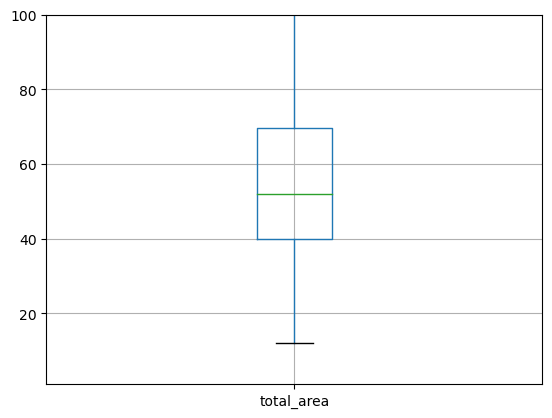

In [34]:
plt.ylim(1, 100)
data.boxplot('total_area')
data['total_area'].describe()

In [35]:
data.sort_values(by='total_area').head(20)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
19904,4,2400000.0,12.00,2017-07-19,1,2.55,5.0,10.000000,2,False,False,False,2.101754,0,санкт-петербург,21314.0,964.0,1,886.0,2,45.0,200
19807,0,3800000.0,13.00,2018-07-04,1,2.65,5.0,10.000000,3,False,False,False,2.276900,0,санкт-петербург,21302.0,1242.0,1,592.0,3,27.0,9
19546,3,1850000.0,13.00,2019-03-11,1,3.40,5.0,7.423098,2,False,False,False,2.276900,0,санкт-петербург,24915.0,5483.0,1,644.0,0,NaN,24
17961,3,1400000.0,13.00,2017-12-03,1,2.60,9.0,7.423098,1,False,False,False,2.276900,0,санкт-петербург,14350.0,15945.0,0,NaN,1,185.0,410
19558,2,1686000.0,13.20,2018-12-17,1,2.65,5.0,7.537300,1,False,False,False,2.311929,0,санкт-петербург,19891.0,4165.0,1,361.0,1,155.0,19
19642,5,1190000.0,14.00,2018-07-29,1,2.65,5.0,11.000000,1,False,False,False,2.000000,0,санкт-петербург,9898.0,11122.0,0,NaN,0,NaN,4
12040,5,1900000.0,15.00,2018-06-27,1,2.50,5.0,8.565114,1,False,False,False,2.627192,0,сосновый бор,NaN,NaN,0,NaN,0,NaN,45
16949,9,1550000.0,15.00,2018-08-21,1,2.70,9.0,8.565114,1,False,False,False,2.627192,0,санкт-петербург,51048.0,16376.0,0,NaN,1,1079.0,42
8886,10,2450000.0,15.50,2018-08-22,0,2.65,5.0,10.000000,2,False,True,False,2.714765,0,санкт-петербург,24326.0,4589.0,0,NaN,1,446.0,27
9412,5,2100000.0,16.00,2017-12-10,0,2.65,6.0,13.000000,1,False,False,True,2.802338,0,санкт-петербург,20735.0,2111.0,2,228.0,3,72.0,3


Предлагаю убрать квартиру с 900 кв.м, хоть у неё стоимость за кв.м. 466666 руб., она единственная с такой большой площадью из всего массива. Интересно, что есть квартиры и с маленким метражом около 12 кв.м, НО почти у всех квартир есть фотографии, может продают часть квартиры/комнату. Оставим.

In [36]:
data = data.loc[data['total_area'] <= 899]

**Посмотрим количество комнат**

count    23616.000000
mean         2.069783
std          1.076514
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

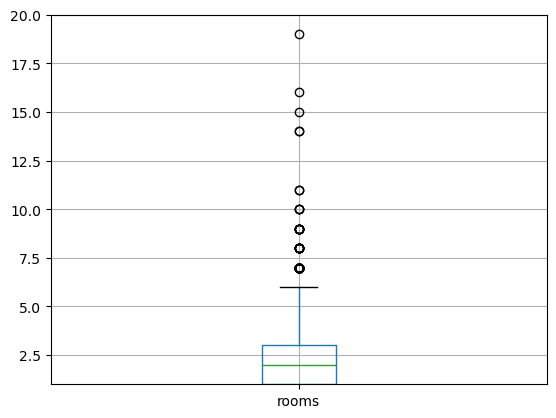

In [37]:
plt.ylim(1, 20)
data.boxplot('rooms')
data['rooms'].describe()

In [38]:
data.sort_values(by='rooms').head(20)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
4955,12,3150000.0,25.00,2018-05-07,0,2.65,25.0,19.000000,17,False,True,False,4.378653,0,санкт-петербург,33386.0,14234.0,0,NaN,0,NaN,112
18622,11,3250000.0,26.00,2018-08-03,0,2.70,17.0,18.000000,12,False,True,False,4.553799,2,санкт-петербург,20630.0,16912.0,0,NaN,2,428.0,215
5312,3,1800000.0,20.00,2018-02-01,0,2.65,19.0,16.000000,10,False,True,False,3.502923,0,деревня кудрово,NaN,NaN,0,NaN,0,NaN,53
9579,9,3450000.0,24.80,2019-02-01,0,2.68,35.0,16.000000,17,False,True,False,4.343624,2,санкт-петербург,18732.0,20444.0,0,NaN,3,80.0,45
22877,2,4280000.0,28.00,2017-10-26,0,2.70,19.0,18.000000,10,False,True,False,4.904092,0,санкт-петербург,18982.0,7206.0,0,NaN,1,415.0,151
21227,0,8200000.0,71.00,2017-07-21,0,5.80,5.0,68.000000,5,False,True,False,12.435375,0,санкт-петербург,20170.0,1261.0,2,295.0,3,366.0,30
5074,18,3500000.0,28.00,2017-07-10,0,2.65,25.0,20.000000,17,False,True,False,4.904092,0,санкт-петербург,6989.0,13205.0,1,535.0,0,NaN,28
19697,17,4200000.0,24.60,2018-03-15,0,2.75,16.0,18.900000,9,False,True,False,4.308595,2,санкт-петербург,34201.0,14069.0,0,NaN,0,NaN,75
5855,3,945750.0,19.50,2017-09-18,0,2.76,3.0,12.700000,2,False,True,False,3.415349,0,поселок городского типа дубровка,NaN,NaN,0,NaN,0,NaN,3
7286,6,2580000.0,30.00,2018-02-07,0,2.65,18.0,19.000000,2,False,False,True,5.254384,0,поселок парголово,52610.0,18787.0,0,NaN,0,NaN,41


In [39]:
data.sort_values(by='rooms', ascending=False).head(20)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
14498,6,32250000.0,374.6,2018-06-09,19,2.65,5.0,264.50000,2,False,False,False,27.60000,0,санкт-петербург,19497.0,3574.0,0,NaN,2,548.0,114
18848,6,28500000.0,270.0,2015-03-02,16,3.00,4.0,180.00000,4,False,False,False,13.00000,1,санкт-петербург,23575.0,4142.0,1,516.0,0,NaN,1365
5358,20,65000000.0,590.0,2019-02-14,15,3.50,6.0,409.00000,3,False,False,False,100.00000,0,санкт-петербург,24447.0,4666.0,1,767.0,0,NaN,14
866,5,25000000.0,363.0,2017-12-23,14,3.16,5.0,222.00000,4,False,False,False,16.60000,0,санкт-петербург,38076.0,7950.0,0,NaN,2,435.0,418
20829,6,28659000.0,245.4,2016-03-31,14,2.65,4.0,168.30000,2,False,False,False,25.90000,0,санкт-петербург,21104.0,2054.0,3,541.0,2,118.0,95
648,3,17500000.0,183.7,2018-07-01,11,3.40,7.0,138.80000,7,False,False,False,13.30000,0,санкт-петербург,23606.0,3148.0,0,NaN,0,NaN,9999
9688,8,33000000.0,194.1,2017-02-07,11,3.43,5.0,129.00000,2,False,False,False,11.90000,0,санкт-петербург,21469.0,1015.0,1,686.0,2,66.0,813
18891,11,40000000.0,290.0,2016-06-21,10,3.50,6.0,189.40000,6,False,False,False,30.00000,1,санкт-петербург,26229.0,4932.0,3,316.0,1,227.0,77
4149,6,23000000.0,272.6,2018-01-11,10,3.14,7.0,145.90000,7,False,False,False,18.80000,1,санкт-петербург,10726.0,12169.0,1,191.0,1,531.0,9999
18119,4,15500000.0,216.1,2016-07-04,10,3.15,5.0,161.40000,2,False,False,False,19.80000,0,санкт-петербург,24353.0,4921.0,1,368.0,0,NaN,11


Комнаты оставим. Где указано - 0, скорее всего это студии или часть квартиры.

**Вывод:** Итак, теперь мы знаем, что датафрейм содержит объявления о продаже недвижимости в Санкт-Петербурге и области за период с ноября 2014 по начало мая 2019 годов.

Мы "почистили" данные, переименовали название столбцов, частично заполнили пропуски, изменили формат столбцов и обработали аномальные значения.

### Посчитайте и добавьте в таблицу новые столбцы

1. Цена одного квадратного метра.
2. День недели, месяц, год публикации объявления (0 — понедельник, 1 — вторник и так далее).
3. Тип этажа квартиры (значения — «первый», «последний», «другой»).
4. Расстояние до центра города в километрах (переведите из м в км и округлите до целых значений).

In [40]:
# Посчитаем цену квадратного метра и переведем к типу int для удобства просмотра
#data['last_price'] = np.floor(pd.to_numeric(data['last_price'], errors='coerce')).astype('Int64')
#data['total_area'] = np.floor(pd.to_numeric(data['total_area'], errors='coerce')).astype('Int64')
data['price_per_square_meter'] = data['last_price'] / data['total_area']
data['price_per_square_meter'] = data['price_per_square_meter'].astype('int')

In [41]:
# Создаем столбец дня недели
data['weekday_exposition'] = data['first_day_exposition'].dt.weekday
# Создаем столбец месяца
data['month_exposition'] = data['first_day_exposition'].dt.month
# Создаем столбец года
data['year_exposition'] = data['first_day_exposition'].dt.year
# Проверим
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,price_per_square_meter,weekday_exposition,month_exposition,year_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.000000,8,False,False,False,25.000000,0,санкт-петербург,18863.0,16028.0,1,482.0,2,755.0,9999,120370,3,3,2019
1,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.600000,1,False,False,False,11.000000,2,поселок шушары,12817.0,18603.0,0,NaN,0,NaN,81,82920,1,12,2018
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.300000,4,False,False,False,8.300000,0,санкт-петербург,21741.0,13933.0,1,90.0,2,574.0,558,92785,3,8,2015
3,0,64900000.0,159.0,2015-07-24,3,2.65,14.0,90.790205,9,False,False,False,27.848234,0,санкт-петербург,28098.0,6800.0,2,84.0,3,234.0,424,408176,4,7,2015
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.000000,13,False,False,False,41.000000,0,санкт-петербург,31856.0,8098.0,2,112.0,1,48.0,121,100000,1,6,2018


In [42]:
# Создаем функцию для заполнения нового столбца с типом этажа
def floor_group(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
data['floor_type'] = data.apply(floor_group, axis=1)

In [43]:
# Приведем расстояние от центра до города к километрам
data['city_centers_nearest'] = data['city_centers_nearest'] / 1000

In [44]:
# Округлим до целых
data['city_centers_nearest'] = data['city_centers_nearest'].round()
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,price_per_square_meter,weekday_exposition,month_exposition,year_exposition
count,23616.000000,2.361600e+04,23616.000000,23616.000000,23616.000000,23531.000000,23616.000000,23616.000000,23616.000000,23616.000000,18093.000000,18116.000000,23616.000000,8053.000000,23616.000000,9072.000000,23616.000000,2.361600e+04,23616.000000,23616.000000,23616.000000
mean,9.862424,6.493991e+06,60.290392,2.069783,2.696852,10.675619,34.562252,5.892742,10.498407,0.590617,28805.237716,14.192151,0.469131,490.819074,0.589981,518.299824,1500.362636,9.933626e+04,2.569021,6.401211,2017.369707
std,5.679938,9.349635e+06,35.189466,1.076514,0.221057,6.590515,22.192293,4.881467,5.992035,0.958245,12637.260120,8.613196,0.748476,342.702274,0.882962,277.837129,3355.125725,4.879758e+04,1.788990,3.491386,1.037781
min,0.000000,1.219000e+04,12.000000,0.000000,2.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,13.000000,1.000000,1.110000e+02,0.000000,1.000000,2014.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.600000,5.000000,19.000000,2.000000,7.000000,0.000000,18575.000000,9.000000,0.000000,287.000000,0.000000,294.000000,45.000000,7.664950e+04,1.000000,3.000000,2017.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.000000,0.000000,26756.000000,13.000000,0.000000,455.000000,0.000000,503.000000,124.000000,9.500000e+04,3.000000,6.000000,2017.000000
75%,14.000000,6.799250e+06,69.717500,3.000000,2.700000,16.000000,42.100000,8.000000,12.000000,1.000000,37310.000000,16.000000,1.000000,612.000000,1.000000,730.000000,390.000000,1.142680e+05,4.000000,10.000000,2018.000000
max,50.000000,4.013000e+08,631.200000,19.000000,6.000000,60.000000,409.000000,33.000000,107.000000,5.000000,84869.000000,66.000000,3.000000,3190.000000,3.000000,1344.000000,9999.000000,1.736842e+06,6.000000,12.000000,2019.000000


### Проведите исследовательский анализ данных

count    23616.000000
mean        60.290392
std         35.189466
min         12.000000
25%         40.000000
50%         52.000000
75%         69.717500
max        631.200000
Name: total_area, dtype: float64

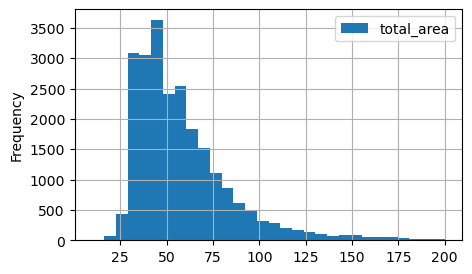

In [45]:
# Изучим общую площадь
data.plot(y = 'total_area', kind = 'hist', bins = 30, grid=True, figsize = (5,3), range = (10, 200))
data['total_area'].describe()

Общая площадь в нашей выборке колеблется от 12 до 631 м2, среднее значение 60, а медиана 52 м2.

count    23616.000000
mean        34.562252
std         22.192293
min          2.000000
25%         19.000000
50%         30.000000
75%         42.100000
max        409.000000
Name: living_area, dtype: float64

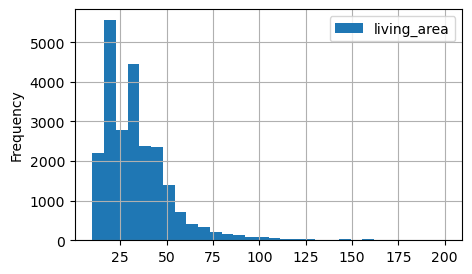

In [46]:
# Изучим жилую площадь
data.plot(y = 'living_area', kind = 'hist', bins = 30, grid=True, figsize = (5,3), range = (10, 200))
data['living_area'].describe()

Жилая площадь в нашей выборке колеблется от 2 до 409 м2, среднее значение 35, а медиана 30 м2.
Среднее значение и медиана подсказывают нам, что это скорее всего это 1-комнатные квартиры или небольшие 2-комнатные.

count    23616.000000
mean        10.498407
std          5.992035
min          1.300000
25%          7.000000
50%          9.000000
75%         12.000000
max        107.000000
Name: kitchen_area, dtype: float64

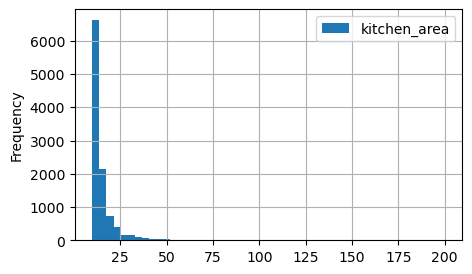

In [47]:
# Изучим площадь кухни
data.plot(y = 'kitchen_area', kind = 'hist', bins = 50, grid=True, figsize = (5,3), range = (10, 200))
data['kitchen_area'].describe()

Площадь кухни в нашей выборке колеблется от 1.3 до 107 м2, среднее значение 10.5, а медиана 9 м2.

In [48]:
# Изучим общую стоимость
data['last_price'] = data['last_price'] / 1000

count     23616.000000
mean       6493.991452
std        9349.634899
min          12.190000
25%        3400.000000
50%        4650.000000
75%        6799.250000
max      401300.000000
Name: last_price, dtype: float64

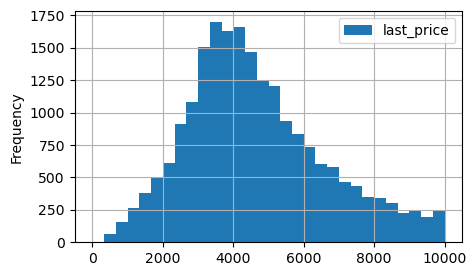

In [49]:
data.plot(y = 'last_price', kind = 'hist', bins = 30, grid=True, range = (0,10000), figsize = (5,3))
data['last_price'].describe()

Цены на недвижимость имеют среднее значение в 6,5 млн руб., медиана 4,7 млн руб. Даже не верится, что раньше были такие цены :)

count    23616.000000
mean         2.069783
std          1.076514
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

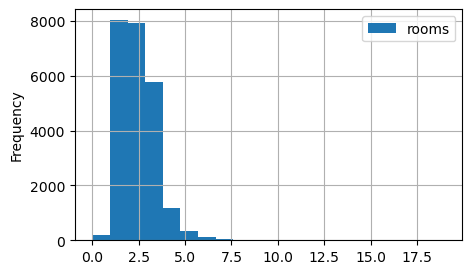

In [50]:
# Изучим число комнат
data.plot(y = 'rooms', kind = 'hist', bins = 20, grid=True, figsize = (5,3))
data['rooms'].describe()

Больше всего однокомнатных и двухкомнатных квартир было на продаже. 

count    23616.000000
mean         2.696852
std          0.221057
min          2.000000
25%          2.600000
50%          2.650000
75%          2.700000
max          6.000000
Name: ceiling_height, dtype: float64

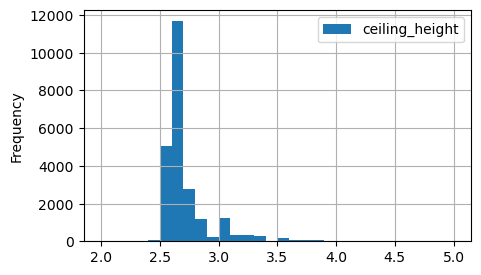

In [51]:
# Изучим высоту потолков
data.plot(y = 'ceiling_height', kind = 'hist', bins = 30, range = (2,5), grid=True, figsize = (5,3))
data['ceiling_height'].describe()

Высота потолков в среднем 2.7 метров

count    23616.000000
mean         5.892742
std          4.881467
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

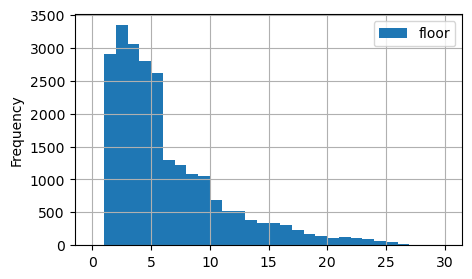

In [52]:
# Изучим этаж квартиры
data.plot(y = 'floor', kind = 'hist', bins = 30, range = (0,30), grid=True, figsize = (5,3))
data['floor'].describe()

В средем продавали квартиры, которые находятся на 1-5 этажах

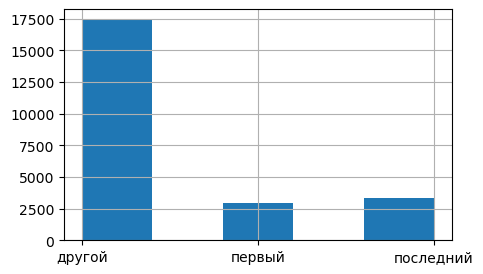

In [53]:
data['floor_type'].hist(bins=5, figsize = (5,3))
plt.show()

По этому графику сложно сделать какой-то вывод. Интересно, что продаж квартир на последнем этаже немного больше, чем на первом.

count    23531.000000
mean        10.675619
std          6.590515
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

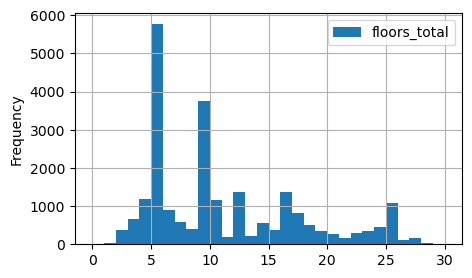

In [54]:
# Изучим общее количество этажей в доме
data.plot(y = 'floors_total', kind = 'hist', bins = 30, range = (0,30), grid=True, figsize = (5,3))
data['floors_total'].describe()

Больше всего продавали квартиры, которые в пятиэтажных или девятиэтажных зданиях

count    18116.000000
mean        14.192151
std          8.613196
min          0.000000
25%          9.000000
50%         13.000000
75%         16.000000
max         66.000000
Name: city_centers_nearest, dtype: float64

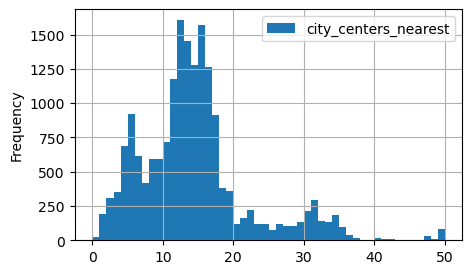

In [55]:
# Изучим расстояние до центра города
data.plot(y = 'city_centers_nearest', kind = 'hist', bins = 50, range = (0,50), grid=True, figsize = (5,3))
data['city_centers_nearest'].describe()

В основном квартиры на продаже были в пределах 2-20 км от центра

count    18093.000000
mean        28.811142
std         12.639935
min          0.000000
25%         19.000000
50%         27.000000
75%         37.000000
max         85.000000
Name: airports_nearest, dtype: float64

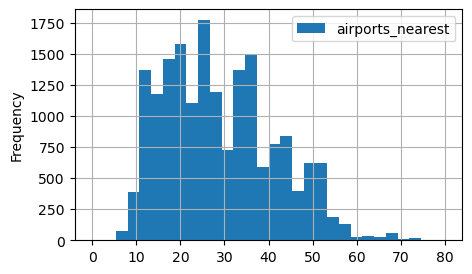

In [56]:
# Изучим расстояние до аэропорта
# Переведем расстояние до аэропорта в км и округлим до целых
data['airports_nearest'] = data['airports_nearest'] / 1000
data['airports_nearest'] = data['airports_nearest'].round()
data.plot(y = 'airports_nearest', kind = 'hist', bins = 30, range = (0,80), grid=True, figsize = (5,3))
data['airports_nearest'].describe()

Разброс большой, в среднем расстояние до аэропорта 29 км

count    8053.000000
mean      490.819074
std       342.702274
min         1.000000
25%       287.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

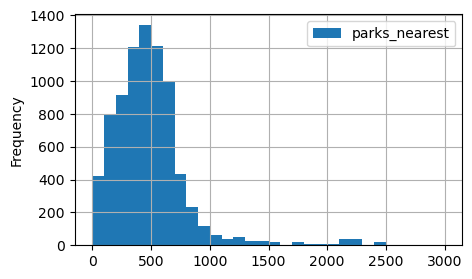

In [57]:
# Изучим расстояние до ближайшего парка
# Расстояние в метрах
data.plot(y = 'parks_nearest', kind = 'hist', bins = 30, range = (0,3000), grid=True, figsize = (5,3))
data['parks_nearest'].describe()

Напоминаю, что в нашей таблице много пропусков с данными о ближайшем парке.
По данным, которые у нас есть, можно сказать, что в среднем ближайший парк расположен в пятистах метрах

count    23616.000000
mean         2.569021
std          1.788990
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: weekday_exposition, dtype: float64

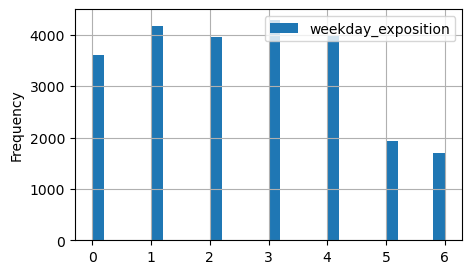

In [58]:
# Изучим дату публикации (день)
data.plot(y = 'weekday_exposition', kind = 'hist', bins = 30, range = (0,6), grid=True, figsize = (5,3))
data['weekday_exposition'].describe()

Напоминаю, что 0 - это понедельник, 1 - вторник и т.д.
Чаще всего объявление выкладывали в будни. Странно, можно предположить, что объявления чаще выкладывали риелторы :)

count    23616.000000
mean         6.401211
std          3.491386
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         12.000000
Name: month_exposition, dtype: float64

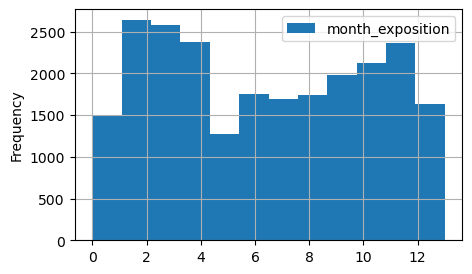

In [59]:
# Изучим дату публикации (месяц)
data.plot(y = 'month_exposition', kind = 'hist', bins = 12, range = (0,13), grid=True, figsize = (5,3))
data['month_exposition'].describe()

Напоминаю, что 1 - это январь, 2 - февраль и т.д.
Чаще всего объявления выкладывали в феврале, марте, апреле и ноябре. Меньше всего в мае.

**Изучим, как быстро продавались квартиры**

Время продажи (медиана): 95 

Время продажи (среднее): 181 



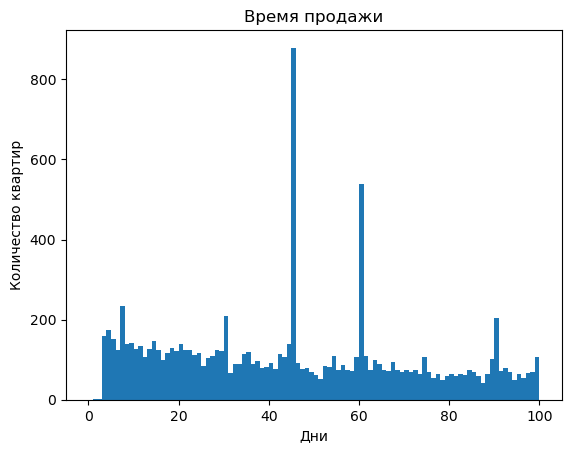

count    20442.000000
mean       180.791410
std        219.846789
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [60]:
# Отбрасываем маркеры пустых значений (напоминаю, что это значение "9999")
print('Время продажи (медиана):', round(data.query('days_exposition != 9999')['days_exposition'].median()),'\n')
print('Время продажи (среднее):', round(data.query('days_exposition != 9999')['days_exposition'].mean()),'\n')
# Гистограма времени продажи
plt.hist(data.query('days_exposition != 9999')['days_exposition'], bins=100, range=(0,100))
plt.title('Время продажи')
plt.xlabel('Дни')
plt.ylabel('Количество квартир')
plt.show()
# Изучаем значения срока продажи
data.query('days_exposition != 9999')['days_exposition'].describe()

**Вывод:** Медианное время продажи - 95 дней. Среднее время продажи - 181 день.
В основном квартиры продаются за срок в 100 дней. Есть большое число квартир, проданных всего за несколько дней после публикации. А также есть варианты, которые продавались несколько десятков месяцев.
Быстрой продажей можно назвать срок в 45 дней и меньше. Долгой продажей - 230 дней (7,5 месяцев) и дольше.

**Изучим зависимость стоимости квартиры от общей площади**

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23616 entries, 0 to 23698
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   total_images            23616 non-null  int64         
 1   last_price              23616 non-null  float64       
 2   total_area              23616 non-null  float64       
 3   first_day_exposition    23616 non-null  datetime64[ns]
 4   rooms                   23616 non-null  int64         
 5   ceiling_height          23616 non-null  float64       
 6   floors_total            23531 non-null  float64       
 7   living_area             23616 non-null  float64       
 8   floor                   23616 non-null  int64         
 9   is_apartment            23616 non-null  bool          
 10  studio                  23616 non-null  bool          
 11  open_plan               23616 non-null  bool          
 12  kitchen_area            23616 non-null  float6

,mean,count,median
total_area,,,
401.00,401300.00,1,401300.00
618.00,300000.00,1,300000.00
285.70,245000.00,1,245000.00
410.00,240000.00,1,240000.00
268.00,190870.00,1,190870.00
...,...,...,...
29.62,1300.00,1,1300.00
14.00,1190.00,1,1190.00
28.60,2034.00,5,1060.00


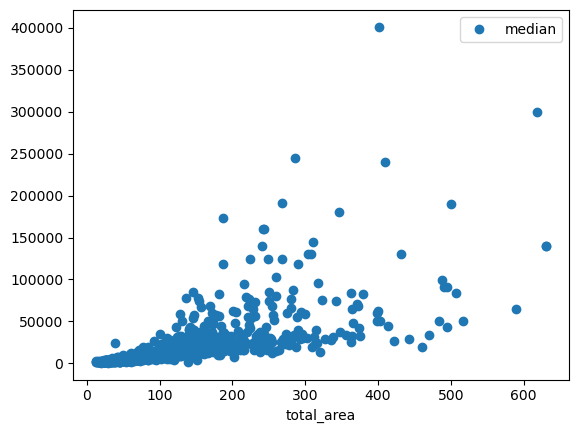

In [62]:
# Изучим зависимость стоимости квартиры от общей площади.
pivot_table_total_area = data.pivot_table(index = 'total_area', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_total_area.columns = ['mean', 'count', 'median']
pivot_table_total_area.plot(y = 'median', style = 'o')

pivot_table_total_area.sort_values('median', ascending = False)

**Вывод:** видим, что зависимость есть. То есть, чем больше площадь, тем выше стоимость!

**Изучим зависимость стоимости квартиры от жилой площади**

,mean,count,median
living_area,,,
204.000000,401300.00,1,401300.00
258.000000,300000.00,1,300000.00
182.800000,245000.00,1,245000.00
218.000000,240000.00,1,240000.00
285.503788,190000.00,2,190000.00
...,...,...,...
25.067233,1100.00,1,1100.00
20.970000,990.00,1,990.00
12.847670,965.78,1,965.78


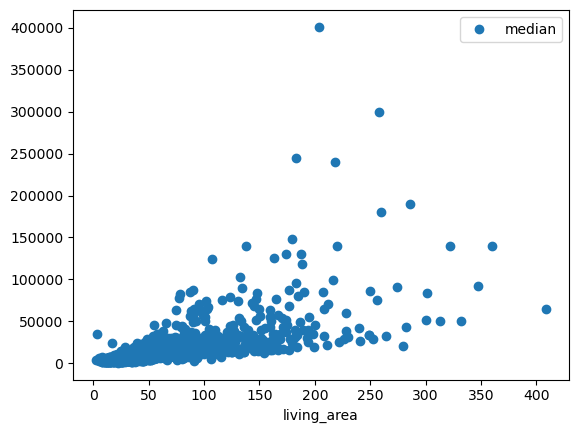

In [63]:
# Изучим зависимость стоимости квартиры от жилой площади.
pivot_table_total_area = data.pivot_table(index = 'living_area', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_total_area.columns = ['mean', 'count', 'median']
pivot_table_total_area.plot(y = 'median', style = 'o')

pivot_table_total_area.sort_values('median', ascending = False)

**Вывод:** видим, что зависимость есть! То есть, чем больше жилая площадь, тем выше стоимость квартиры!

**Изучим зависимость стоимости квартиры от площади кухни**

,mean,count,median
kitchen_area,,,
70.000000,162150.00,2,162150.00
87.573064,150000.00,1,150000.00
42.210217,140000.00,1,140000.00
66.555529,131000.00,1,131000.00
53.244423,130278.28,1,130278.28
...,...,...,...
6.532951,1300.00,1,1300.00
5.910000,1300.00,1,1300.00
7.688915,1100.00,1,1100.00


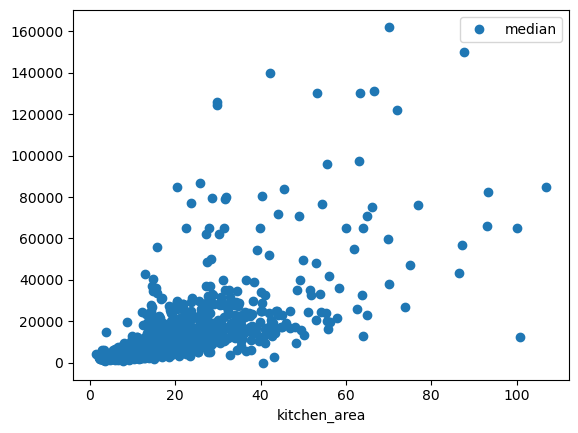

In [64]:
# Изучим зависимость стоимости квартиры от площади кухни.
pivot_table_total_area = data.pivot_table(index = 'kitchen_area', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_total_area.columns = ['mean', 'count', 'median']
pivot_table_total_area.plot(y = 'median', style = 'o')

pivot_table_total_area.sort_values('median', ascending = False)

**Вывод:** видим, что зависимость есть! То есть, чем больше площадь кухни, тем выше стоимость квартиры!

**Изучим зависимость стоимости квартиры от числа комнат**

,mean,count,median
rooms,,,
15,65000.000000,1,65000.0
19,32250.000000,1,32250.0
16,28500.000000,1,28500.0
14,26829.500000,2,26829.5
11,25250.000000,2,25250.0
7,39202.311655,58,24900.0
9,34152.362500,8,23750.0
8,50224.166667,12,23095.0
10,26166.666667,3,23000.0


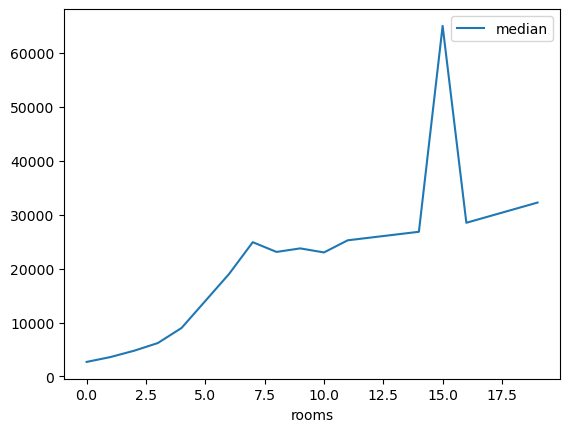

In [65]:
# Изучим зависимость стоимости квартиры от числа комнат.
pivot_table_rooms = data.pivot_table(index = 'rooms', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_rooms.columns = ['mean', 'count', 'median']
pivot_table_rooms.plot(y = 'median')

pivot_table_rooms.sort_values('median', ascending = False)

**Вывод:** чем больше количество комнат, тем ниже стоимость квадратного метра.

**Изучим зависимость стоимости квартиры от этажа**

,mean,count,median
floor_type,,,
другой,6678.704494,17383,4850.0
первый,4801.651097,2909,3900.0
последний,7009.079086,3324,4300.0


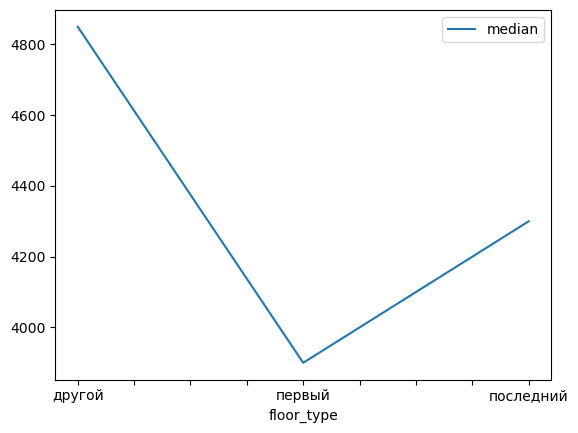

In [66]:
# Изучим зависимость стоимости квартиры от этажа.
pivot_table_floor_category = data.pivot_table(index = 'floor_type', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_floor_category.columns = ['mean', 'count', 'median']
pivot_table_floor_category.plot(y = 'median')
pivot_table_floor_category

**Вывод:** как правило квартиры на первом этаже дешевле квартир на других и последнем этаже. Так же видим, что не всегда квартира на последнем этаже дороже.

**Изучим зависимость стоимости квартиры от даты размещения**

,mean,count,median
weekday_exposition,,,
1,6395.907007,4168,4714.595
2,6522.679756,3958,4700.000
0,6515.023156,3601,4650.000
3,6713.689418,4283,4650.000
4,6368.726329,3984,4580.000
5,6591.865579,1931,4560.000
6,6250.719671,1691,4550.000


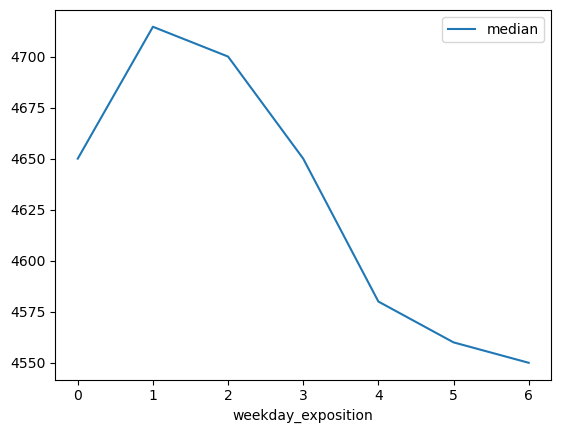

In [67]:
# Изучим зависимость стоимости квартиры от даты размещения: дня недели.
pivot_table_weekday_exposition = data.pivot_table(index = 'weekday_exposition', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_weekday_exposition.columns = ['mean', 'count', 'median']
pivot_table_weekday_exposition.plot(y = 'median')

pivot_table_weekday_exposition.sort_values('median', ascending = False)

**Вывод:** видим, что чем ближе ко вторнику выставлены объявления, тем в среднем выше стоимость, но незначительно! По воскресеньям стоимость самая низкая!
Полагаю, что стоимость выставленной на продажу недвижимости зависит от общей активности людей, так как именно в рабочие дни мы видим более высокие цены.

,mean,count,median
month_exposition,,,
4,6742.074711,2371,4800.0
9,6448.503873,1976,4700.0
11,6463.328135,2365,4700.0
12,6757.890692,1635,4700.0
3,6370.616392,2576,4687.5
2,6466.913903,2635,4650.0
7,6637.378624,1687,4650.0
1,6665.979656,1490,4600.0
8,6357.157163,1739,4570.0


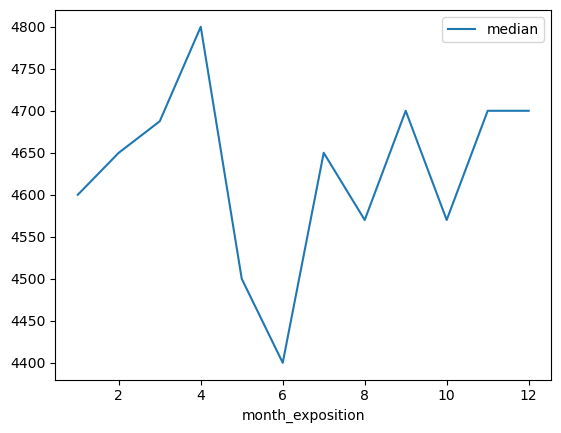

In [68]:
# Изучим зависимость стоимости квартиры от даты размещения: месяца.
pivot_table_month_exposition = data.pivot_table(index = 'month_exposition', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_month_exposition.columns = ['mean', 'count', 'median']
pivot_table_month_exposition.plot(y = 'median')

pivot_table_month_exposition.sort_values('median', ascending = False)

**Вывод:** самая высокая стоимость квартиры в апреле, сентябре и ноябре! Самая низкая стоимость в мае и июне! На рынке недвижимости, как и во многих других сферах присутствует сезонность - в начале лета мы видим наименьшее предложение как по количеству, так и по стоимости недвижимости. Наверное, это связано с отпусками.

,mean,count,median
year_exposition,,,
2014,12046.600176,136,7640.0
2015,8601.382818,1171,5350.0
2019,6786.280358,2872,5050.0
2018,5953.065963,8501,4550.0
2016,6829.859647,2764,4540.0
2017,6445.986567,8172,4500.0


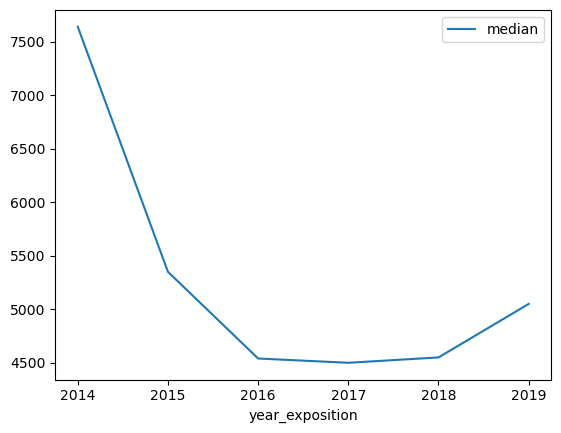

In [69]:
# Изучим зависимость стоимости квартиры от даты размещения: года.
pivot_table_year_exposition = data.pivot_table(index = 'year_exposition', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_year_exposition.columns = ['mean', 'count', 'median']
pivot_table_year_exposition.plot(y = 'median')

pivot_table_year_exposition.sort_values('median', ascending = False)

**Вывод:** видим, что с 2014 до 2017 года цена падала, но далее начала увеличиваться! В СРЕДНЕМ! Мы не рассматриваем сегментацию рынка и по факту стоимость аналогичных квартир могла себя вести абсолютно иначе от года к году!

**Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра.**

In [70]:
locality_pivot_table = data.pivot_table(index = 'locality_name', values = 'price_per_square_meter', aggfunc=['count', 'mean'])
locality_pivot_table.columns = ['count', 'mean']
locality_pivot_table = locality_pivot_table.sort_values('count', ascending = False).head(10)
locality_pivot_table

,count,mean
locality_name,,
санкт-петербург,15700,114693.365223
поселок мурино,554,85655.756318
поселок шушары,440,78676.904545
всеволожск,398,68654.007538
пушкин,369,103125.373984
колпино,338,75424.150888
поселок парголово,327,90175.489297
гатчина,306,68757.225490
деревня кудрово,299,92473.086957


In [71]:
#самая высокая стоимость
locality_pivot_table[locality_pivot_table['mean']==locality_pivot_table['mean'].max()]

,count,mean
locality_name,,
санкт-петербург,15700,114693.365223


In [72]:
#самая низкая стоимость
locality_pivot_table[locality_pivot_table['mean']==locality_pivot_table['mean'].min()]

,count,mean
locality_name,,
выборг,237,58141.489451


**Вывод:** Наибольшая средняя стоимость квадратного метра, как и ожидалось, в Санкт-Петербурге. Затем идёт Пушкин, что, вероятно, вызвано хорошей застройкой и большим количеством парков. Затем идут районы, фактически являющиеся Санкт-Петербургом и непосредственно к нему примыкают. Из топ-10 наименьшая стоимость в Гатчине и Всеволожске, из которых далеко ехать до Санкт-Петербурга, а также небольшой по численности населения Выборг, расположенный на большом расстоянии от Санкт-Петербурга.

**Выделим квартиры в Санкт-Петербурге с помощью столбца locality_name и вычеслим среднюю цену каждого километра. Опишем, как стоимость объектов зависит от расстояния до центра города.**

,mean
city_centers_nearest,
0,245833.111111
1,177004.963542
2,157848.564516
3,121225.415473
4,130732.642857
5,140509.339130
6,151011.750809
7,156176.445238
8,124360.035413


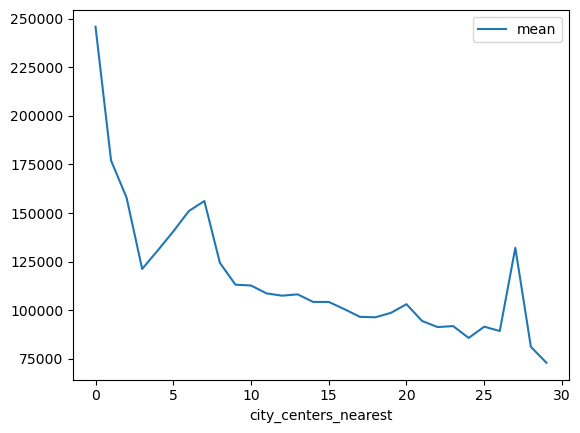

In [73]:
data['city_centers_nearest'] = data['city_centers_nearest'].fillna(999999)
data['city_centers_nearest'] = data['city_centers_nearest'].astype('int')
pivot_table_km = data.query('locality_name == "санкт-петербург" and city_centers_nearest !=999999').pivot_table(index = 'city_centers_nearest', values = 'price_per_square_meter', aggfunc = 'mean')
pivot_table_km.columns = ['mean']
pivot_table_km.plot()
pivot_table_km

**Вывод:** Четкой зависимости нет, но в среднем, чем ближе к центру, тем стоимость кв.м дороже. И мы не знаем, какую точку программа считает центром. Центр города заканчивается примерно на 7 км.

In [74]:
data.corr()['last_price'].sort_values()

city_centers_nearest     -0.197481
ponds_nearest            -0.105636
year_exposition          -0.048220
airports_nearest         -0.030471
studio                   -0.029179
parks_nearest            -0.020226
floors_total             -0.011713
open_plan                -0.009772
month_exposition         -0.002303
weekday_exposition       -0.002224
balcony                   0.005918
floor                     0.020929
is_apartment              0.032331
days_exposition           0.082620
total_images              0.117081
parks_around_3000         0.229407
ponds_around_3000         0.231277
ceiling_height            0.342545
rooms                     0.391977
kitchen_area              0.539074
living_area               0.623914
total_area                0.695370
price_per_square_meter    0.745143
last_price                1.000000
Name: last_price, dtype: float64

### Общий вывод

Мы обработали полученный архив данных - обработали пропущенные значения там, где это необходимо, заменили типы данных на необходимые для удобной работы. Посчитали и добавили в таблицу цену квадратного метра жилья, вывели из даты дни недели, месяцы и года размещения объявлений, добавили категории по этажам квартир.

**Факторы, влияющие на стоимость**

- На стоимость больше влияет площадь квартиры, нежели число комнат. Т.е. могут быть дорогие квартиры с малым числом комнат, но где комнаты просторные.
- Первый этаж значительно дешевле остальных вариантов.
- Квартиры, которые находятся в центре Санкт-Петербурга в радиусе 3 км - самые дорогие.
- Так же на стоимость квартиры влияет наличие парка/водоема.

**Стоимость квадратного метра в топ-10 населённых пунктов**

- Дороже всего квадратный метр в Санкт-Петербурге - 114693
- Дешевле всего квадратный метр в Выборге - 58141

**Срок продажи квартиры**
- Чаще всего квартиру продают за 95 дней. Если меньше 45 дней, то это быстро, если дольше 230 дней - это долго.



**Рекомендации для площадки объявлений**
- Уделить внимание правилам валидации на сервере, чтобы больше не сталкиваться с проблемой отсутствующих значений.
- Продумать сценарий, при котором данные до парков, водоемов, аэропортов будут подтягиваться автоматически.
- Считать расстояние в километрах и целых числах.


**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения там, где это возможно
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  устранены неявные дубликаты в названиях населённых пунктов
- [x]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [x]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [x]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [x]  посчитано и добавлено в таблицу: месяц публикации объявления
- [x]  посчитано и добавлено в таблицу: год публикации объявления
- [x]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [x]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [x]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [x]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [x]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [x]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [x]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод